### **Clustering**

El clustering es la tarea de dividir el conjunto de datos en grupos, llamados *clusters*. El objetivo es agrupar los datos de tal manera que:

* Los puntos dentro de un mismo clúster sean lo más similares posible (alta cohesión interna).
* Los puntos de diferentes clústeres sean lo más distintos posible (alta separación entre clústeres).

De forma similar a los algoritmos de clasificación, los algoritmos de clustering asignan (o “predicen”) un número o etiqueta a cada punto de datos, indicando a qué grupo pertenece.

#### **Tipos de algoritmos de clustering**

1. **Particionales**

   * **k-Means**:

     * Inicializa k centroides aleatorios.
     * Asigna cada punto al centroide más cercano (por ejemplo, por distancia Euclídea).
     * Recalcula los centroides como la media de los puntos asignados.
     * Repite hasta converger o alcanzar un número máximo de iteraciones.
   * **k-Medoids (PAM)**:

     * Similar a k-Means, pero cada clúster está representado por un punto real (medoide) en lugar de la media, lo que es más robusto ante valores atípicos.

2. **Jerárquicos**

   * **Aglomerativo (bottom-up)**:

     * Comienza con cada punto como un clúster separado.
     * En cada paso, fusiona los dos clústeres más similares, según un criterio de enlace (simple, completo, promedio).
     * Genera un dendrograma que se puede "cortar" para obtener el número deseado de clústeres.
   * **Divisivo (top-down)**:

     * Parte de un solo clúster que contiene todos los puntos.
     * En cada paso, divide un clúster en dos, típicamente usando k-Means con k=2.

3. **Basados en densidad**

   * **DBSCAN**:

     * Agrupa puntos densamente conectados (vecinos dentro de un radio ε).
     * Los puntos con al menos *minPts* vecinos son *puntos centrales*; otros pueden ser *puntos frontera* o *ruido*.
   * **OPTICS**:

     * Similar a DBSCAN, pero capaz de detectar clústeres de densidades variables sin fijar un radio global.

4. **Basados en modelos**

   * **EM (Expectation–Maximization) para mezclas Gaussianas**:

     * Asume que los datos provienen de la combinación de varias distribuciones gaussianas.
     * Alterna entre asignar probabilidades de pertenencia (*E-step*) y ajustar parámetros de las Gaussianas (*M-step*).

#### **Métricas de distancia y similitud**

* **Distancia Euclídea**: Ideal para datos continuos en espacio ℝⁿ.
* **Distancia de Manhattan**: Más robusta ante dimensiones con escalas diferentes.
* **Distancia de Mahalanobis**: Tiene en cuenta la covarianza y escala de las variables.
* **Coeficiente de correlación de Pearson**: Para medir similitud de forma (series temporales, vectores normalizados).
* **Distancias específicas** (Jaccard, Hamming) para datos binarios o categóricos.

#### **Evaluación de resultados**

* **Índice de Silhouette**:

  $$
  s(i) = \frac{b(i) - a(i)}{\max\{a(i), b(i)\}}
  $$

  donde *a(i)* es la distancia media del punto *i* a los demás de su clúster, y *b(i)* es la distancia media al clúster más cercano. Valores cercanos a 1 indican buena asignación.

* **Índice de Dunn**:
  Relaciona la separación mínima entre clústeres con el diámetro máximo dentro de clústeres; valores altos son mejores.

* **Coeficiente de correlación de Rand** (o *Adjusted Rand Index*):
  Compara la coincidencia entre dos particiones (por ejemplo, clustering vs. etiquetas verdaderas).

* **Validación interna vs. externa**:

  * *Interna*: sólo usa los propios datos y distancias (Silhouette, Dunn).
  * *Externa*: compara contra una clasificación “verdadera” conocida (Rand, F-measure).

#### **Estrategias de escalado y paralelización**

* **Map-Reduce para k-Means**

  * Mapa: cada nodo asigna puntos a centroides y calcula sumas parciales.
  * Reduce: agrega sumas y cuentas para recalcular centroides globales.

* **Mini-batch k-Means**

  * Procesa pequeños lotes de datos para actualizar centroides, reduciendo memoria y acelerando convergencia en datasets muy grandes.

* **Aceleración con GPUs**

  * Implementaciones que aprovechan paralelismo masivo para calcular distancias en grandes volúmenes de datos.



### **K-means clustering**

El algoritmo de **K-means** es uno de los métodos de clustering más sencillos y utilizados. Su objetivo es encontrar **centroides** que representen regiones de los datos. El procedimiento alterna entre dos pasos:

1. Asignar cada punto de datos al centroide más cercano.  
2. Recalcular cada centroide como la media de los puntos que se le han asignado.

El algoritmo termina cuando las asignaciones de puntos a clústeres no cambian de una iteración a la siguiente.


In [3]:
%matplotlib inline
import numpy as np

from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances
import matplotlib.pyplot as plt
import matplotlib as mpl
from cycler import cycler
import warnings
warnings.filterwarnings('ignore')

**Funciones auxiliares**

In [5]:
from matplotlib.colors import  colorConverter, ListedColormap
cm3 = ListedColormap(['#0000aa', '#ff2020', '#50ff50'])
cm2 = ListedColormap(['#0000aa', '#ff2020'])

def dibuja_dispersion_discreta(x1, x2, y=None, marcadores=None, s=10, ax=None,
                     etiquetas=None, relleno=.2, alfa=1, c=None, anchobordemarcador=None):
    """Adaptacion de la funcion matplotlib.pyplot.scatter a dibujar clases o  clusters"""
    
    if ax is None:
        ax = plt.gca()

    if y is None:
        y = np.zeros(len(x1))

    unico_y = np.unique(y)

    if marcadores is None:
        marcadores= ['o', '^', 'v', 'D', 's', '*', 'p', 'h', 'H', '8', '<', '>'] * 10

    if len(marcadores) == 1:
        marcadores = marcadores * len(unico_y)

    if etiquetas is None:
        etiquetas = unico_y

    # lineas en el sentido de matplotlib
    lineas = []

    actual_cycler = mpl.rcParams['axes.prop_cycle']

    for i, (yy, cycle) in enumerate(zip(unico_y, actual_cycler())):
        mascara = y == yy
        # if c is ninguno, use color cycle
        if c is None:
            color = cycle['color']
        elif len(c) > 1:
            color = c[i]
        else:
            color = c
        # bordes claros para marcadores oscuros
        if np.mean(colorConverter.to_rgb(color)) < .4:
            colorbordemarcador = "grey"
        else:
            colorbordemarcador = "black"

        lineas.append(ax.plot(x1[mascara], x2[mascara], marcadores[i], markersize=s,
                             label=etiquetas[i], alpha=alfa, c=color,
                             markeredgewidth=anchobordemarcador,
                             markeredgecolor=colorbordemarcador)[0])

    if relleno != 0:
        pad1 = x1.std() * relleno
        pad2 = x2.std() * relleno
        xlim = ax.get_xlim()
        ylim = ax.get_ylim()
        ax.set_xlim(min(x1.min() - pad1, xlim[0]), max(x1.max() + pad1, xlim[1]))
        ax.set_ylim(min(x2.min() - pad2, ylim[0]), max(x2.max() + pad2, ylim[1]))

    return lineas

In [6]:
def dibuja_clasificacion_2d(clasificador, X, relleno=False, ax=None, eps=None, alfa=1, cm=cm3):
    # multiclase
    if eps is None:
        eps = X.std() / 2.

    if ax is None:
        ax = plt.gca()

    x_min, x_max = X[:, 0].min() - eps, X[:, 0].max() + eps
    y_min, y_max = X[:, 1].min() - eps, X[:, 1].max() + eps
    xx = np.linspace(x_min, x_max, 1000)
    yy = np.linspace(y_min, y_max, 1000)

    X1, X2 = np.meshgrid(xx, yy)
    X_grid = np.c_[X1.ravel(), X2.ravel()]
    valores_decision = clasificador.predict(X_grid)
    ax.imshow(valores_decision.reshape(X1.shape), extent=(x_min, x_max,
                        y_min, y_max), aspect='auto', origin='lower', alpha=alfa, cmap=cm)
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    ax.set_xticks(())
    ax.set_yticks(())

In [7]:
import os
os.environ["OMP_NUM_THREADS"] = "1"

def dibuja_algoritmos_kmeans():
    X, y = make_blobs(random_state=1)
    with mpl.rc_context(rc={'axes.prop_cycle': cycler('color', ['#0000aa',
                                                                '#ff2020',
                                                                '#50ff50'])}):
        fig, axes = plt.subplots(3, 3, figsize=(10, 8), subplot_kw={'xticks': (), 'yticks': ()})
        axes = axes.ravel()
        axes[0].set_title("Entrada de datos")
        dibuja_dispersion_discreta(X[:, 0], X[:, 1], ax=axes[0], marcadores=['o'], c='w')
        axes[1].set_title("Inicializacion")
        inicio= X[:3, :]
        dibuja_dispersion_discreta(X[:, 0], X[:, 1], ax=axes[1], marcadores=['o'], c='w')
        dibuja_dispersion_discreta(inicio[:, 0], inicio[:, 1], [0, 1, 2], ax=axes[1], marcadores=['^'], anchobordemarcador=2)
        axes[2].set_title("Asignamos puntos (1)")
        km = KMeans(n_clusters=3, init=inicio, max_iter=1, n_init=1).fit(X)
        centros = km.cluster_centers_
        # necesitamos calcular las etiquetas. 
        etiquetas = np.argmin(pairwise_distances(inicio, X), axis=0)
        dibuja_dispersion_discreta(X[:, 0], X[:, 1], etiquetas, marcadores=['o'],
                         ax=axes[2])
        dibuja_dispersion_discreta(inicio[:, 0], inicio[:, 1], [0, 1, 2], ax=axes[2], marcadores=['^'], anchobordemarcador=2)

        axes[3].set_title("Recalculamos los centros (1)")
        dibuja_dispersion_discreta(X[:, 0], X[:, 1], etiquetas, marcadores=['o'],
                         ax=axes[3])
        dibuja_dispersion_discreta(centros[:, 0], centros[:, 1], [0, 1, 2], ax=axes[3], marcadores=['^'], anchobordemarcador=2)

        axes[4].set_title("Reasignar puntos (2)")
        km = KMeans(n_clusters=3, init=inicio, max_iter=1, n_init=1).fit(X)
        etiquetas = km.labels_
        dibuja_dispersion_discreta(X[:, 0], X[:, 1], etiquetas, marcadores=['o'],
                         ax=axes[4])
        dibuja_dispersion_discreta(centros[:, 0], centros[:, 1], [0, 1, 2], ax=axes[4], marcadores=['^'], anchobordemarcador=2)

        km = KMeans(n_clusters=3, init=inicio, max_iter=2, n_init=1).fit(X)
        axes[5].set_title("Recalculamos el centro (2)")
        centros = km.cluster_centers_
        dibuja_dispersion_discreta(X[:, 0], X[:, 1], etiquetas, marcadores=['o'],
                         ax=axes[5])
        dibuja_dispersion_discreta(centros[:, 0], centros[:, 1], [0, 1, 2], ax=axes[5], marcadores=['^'], anchobordemarcador=2)

        axes[6].set_title("Reasignamos puntos (3)")
        etiquetas = km.labels_
        dibuja_dispersion_discreta(X[:, 0], X[:, 1], etiquetas, marcadores=['o'],
                         ax=axes[6])
        marcadores= dibuja_dispersion_discreta(centros[:, 0], centros[:, 1], [0, 1, 2], ax=axes[6], marcadores=['^'], anchobordemarcador=2)

        axes[7].set_title("Recalculamos centros (3)")
        km = KMeans(n_clusters=3, init=inicio, max_iter=3, n_init=1).fit(X)
        centros = km.cluster_centers_
        dibuja_dispersion_discreta(X[:, 0], X[:, 1], etiquetas, marcadores=['o'],
                         ax=axes[7])
        dibuja_dispersion_discreta(centros[:, 0], centros[:, 1], [0, 1, 2], ax=axes[7], marcadores=['^'], anchobordemarcador=2)
        axes[8].set_axis_off()
        axes[8].legend(marcadores, ["Cluster 0", "Cluster 1", "Cluster 2"], loc='best')

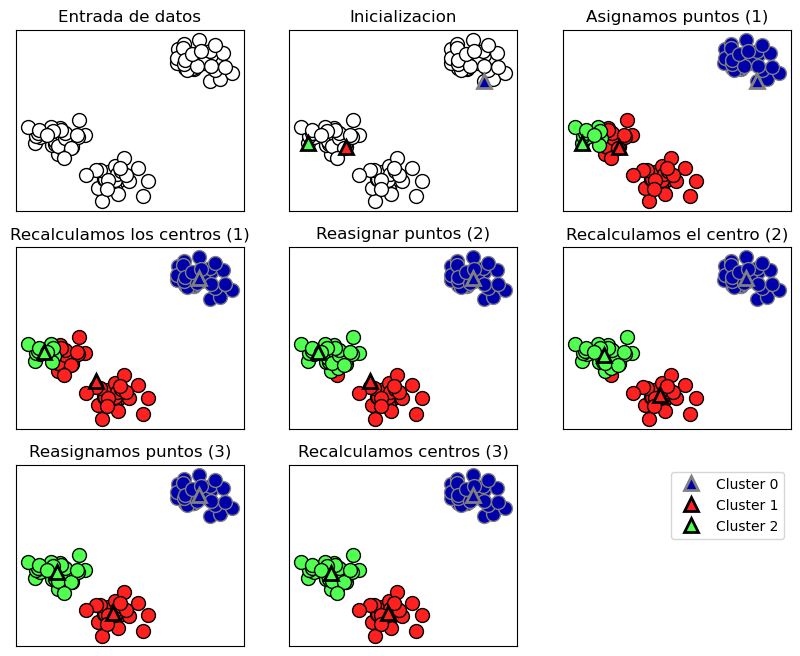

In [8]:
dibuja_algoritmos_kmeans()

Los **centroides** de los clústeres se representan con triángulos, mientras que los **puntos de datos** aparecen como círculos. Los colores indican la pertenencia de cada punto a un clúster.

En este caso hemos especificado que deseamos **tres clústeres**, por lo que el algoritmo se inicializa seleccionando aleatoriamente tres puntos de datos como centroides. A continuación comienza el proceso iterativo:

1. **Asignación**: cada punto de datos se asigna al centroide más cercano.  
2. **Actualización**: cada centroide se recalcula como la media de los puntos asignados.  

Estos dos pasos se repiten. Tras la tercera iteración, las asignaciones de puntos a centroides no cambiaron, por lo que el algoritmo concluye.

Dado un nuevo conjunto de puntos, K-means los asignará al centroide más cercano. El siguiente ejemplo muestra las regiones (fronteras de Voronoi) correspondientes a los centroides aprendidos en el gráfico anterior:


In [10]:
def dibuja_frontera_kmeans():
    X, y = make_blobs(random_state=1)
    inicio = X[:3, :]
    km = KMeans(n_clusters=3, init=inicio, max_iter=2, n_init=1).fit(X)
    dibuja_dispersion_discreta(X[:, 0], X[:, 1], km.labels_, marcadores=['o'])
    dibuja_dispersion_discreta(km.cluster_centers_[:, 0], km.cluster_centers_[:, 1], [0, 1, 2], marcadores=['^'], anchobordemarcador=2)
    dibuja_clasificacion_2d(km, X, cm=cm3, alfa=.4)


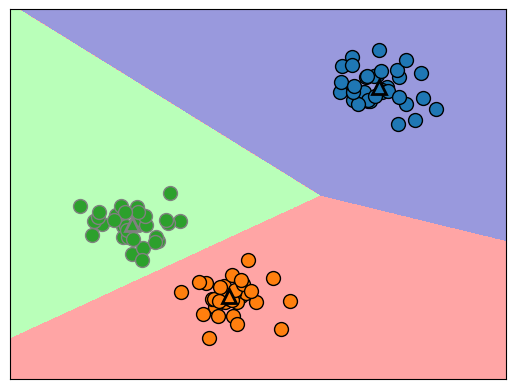

In [11]:
dibuja_frontera_kmeans()

La aplicación de K-means con scikit-learn es muy sencilla. En este ejemplo usamos los mismos datos artificiales de los gráficos anteriores. Primero, importamos e instanciamos la clase `KMeans`, indicando el número de clústeres que queremos (parámetro `n_clusters`). Luego llamamos al método `fit` con el conjunto de datos:


In [13]:
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans

# generamos datos superficiales con dos dimensiones
X, y = make_blobs(random_state=1)

# construimos el modelo de clustering
kmeans = KMeans(n_clusters=3)
kmeans.fit(X)

KMeans(n_clusters=3)

In [14]:
print("Miembros de los clustering:\n{}".format(kmeans.labels_))

Miembros de los clustering:
[1 2 2 2 0 0 0 2 1 1 2 2 0 1 0 0 0 1 2 2 0 2 0 1 2 0 0 1 1 0 1 1 0 1 2 0 2
 2 2 0 0 2 1 2 2 0 1 1 1 1 2 0 0 0 1 0 2 2 1 1 2 0 0 2 2 0 1 0 1 2 2 2 0 1
 1 2 0 0 1 2 1 2 2 0 1 1 1 1 2 1 0 1 1 2 2 0 0 1 0 1]


Como pedimos tres clusters, los clusters están numerados del `0` al `2`. También se puede asignar etiquetas de clúster a nuevos puntos, utilizando el método `predict`. Cada nuevo punto se asigna al centro de clúster más cercano al predecir, pero el modelo existente no se cambia. 

La ejecución de `predict `en el conjunto de entrenamiento resulta  el mismo resultado que `labels_`:

In [16]:
print(kmeans.predict(X))

[1 2 2 2 0 0 0 2 1 1 2 2 0 1 0 0 0 1 2 2 0 2 0 1 2 0 0 1 1 0 1 1 0 1 2 0 2
 2 2 0 0 2 1 2 2 0 1 1 1 1 2 0 0 0 1 0 2 2 1 1 2 0 0 2 2 0 1 0 1 2 2 2 0 1
 1 2 0 0 1 2 1 2 2 0 1 1 1 1 2 1 0 1 1 2 2 0 0 1 0 1]


El clustering es similar a la clasificación, ya que cada elemento recibe una etiqueta. Sin embargo, no existe una **verdad absoluta** y, por lo tanto, las etiquetas en sí mismas no tienen un significado a priori. Es posible que el grupo 3 encontrado por el algoritmo contenga solo las caras de una misma persona; sin embargo, solo podrás confirmarlo después de revisar las imágenes, ya que el número 3 es completamente arbitrario. La única información que el algoritmo aporta es que todas las caras etiquetadas como "3" son similares.

En el clustering que acabamos de calcular sobre el conjunto de datos bidimensional, no deberíamos asignar ningún significado al hecho de que un grupo se etiquete como **0** y otro como **1**. Si ejecutas el algoritmo de nuevo, podrías obtener una numeración distinta debido a la aleatoriedad en la inicialización.


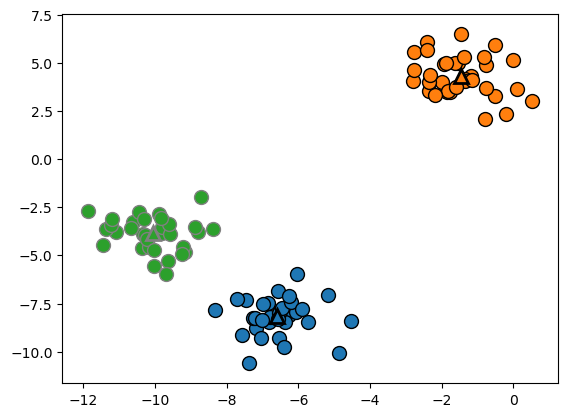

In [18]:
# Las asignaciones de clúster y los centros de clúster encontrados por k-means con tres clusters

dibuja_dispersion_discreta(X[:, 0], X[:, 1], kmeans.labels_, marcadores='o')
dibuja_dispersion_discreta( kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], [0, 1, 2], marcadores='^', anchobordemarcador=2)

También podemos usar más o menos centros de clusters:

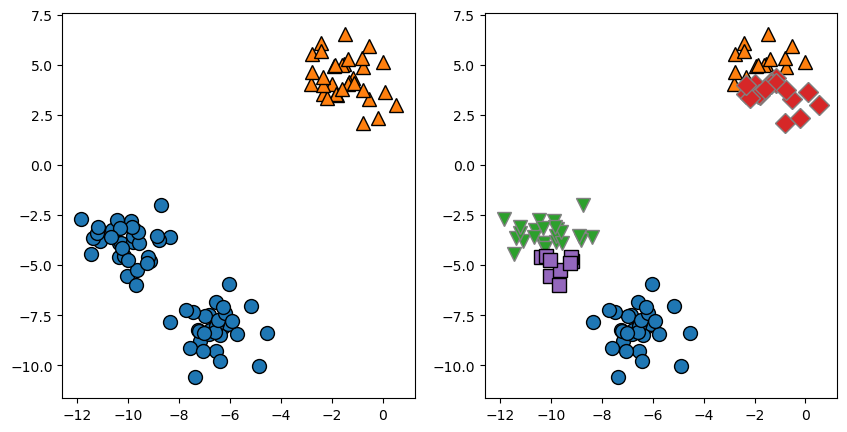

In [20]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
# usando dos centros de clusters:
kmeans = KMeans(n_clusters=2)
kmeans.fit(X)
asignamientos = kmeans.labels_
dibuja_dispersion_discreta(X[:, 0], X[:, 1], asignamientos, ax=axes[0])

# usando cinco centros de clustering:
kmeans = KMeans(n_clusters=5)
kmeans.fit(X)
asignamientos = kmeans.labels_
dibuja_dispersion_discreta(X[:, 0], X[:, 1], asignamientos, ax=axes[1])

### **Casos en que falla k-means**

Aunque se conozca el número "correcto" de clusters en un conjunto de datos, k-means puede no ser capaz de detectarlos. Cada cluster se define únicamente por su centro, por lo que adopta formas convexas y, por tanto, solo captura distribuciones relativamente simples. 

Además, asume que todos los clusters tienen un "diámetro" similar: la frontera entre ellos siempre queda exactamente a mitad de camino entre sus centros. Esto, en ocasiones, conduce a resultados contraintuitivos.


Text(0, 0.5, 'Caracteristica 1')

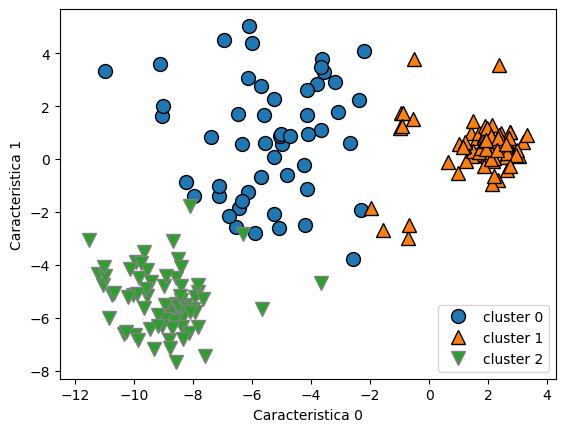

In [22]:
X_c, y_c = make_blobs(n_samples=200, cluster_std=[1.0, 2.5, 0.5], random_state=170)
y_pred = KMeans(n_clusters=3, random_state=0).fit_predict(X_c)
dibuja_dispersion_discreta(X_c[:, 0], X_c[:, 1], y_pred)
plt.legend(["cluster 0", "cluster 1", "cluster 2"], loc='best')
plt.xlabel("Caracteristica 0")
plt.ylabel("Caracteristica 1")

Podrías haber esperado que la región densa en la parte inferior izquierda fuera el primer cluster, la región densa en la parte superior derecha el segundo, y la menos densa en el centro el tercero. En cambio, tanto el **cluster 0** como el **cluster 1** incluyen puntos muy alejados del resto, "extendiéndose" hacia el centro.

Además, k-means asume que todas las direcciones son igualmente relevantes para cada cluster. La siguiente gráfica muestra un conjunto de datos bidimensional con tres grupos claramente separados, pero estirados en diagonal. Dado que k-means solo considera la distancia al centro de su cluster más cercano, no puede manejar este tipo de distribuciones:



Text(0, 0.5, 'Caracteristica 1')

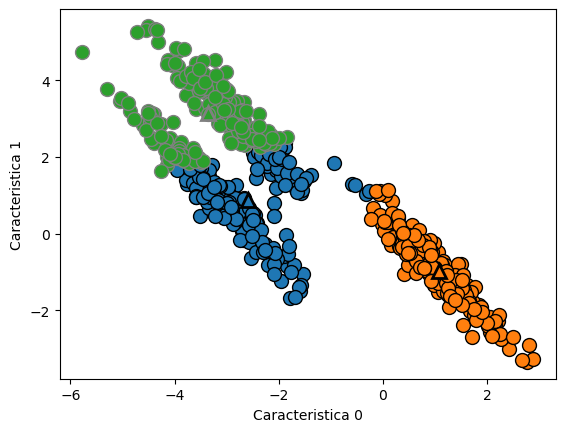

In [24]:
# Genera algunos datos de clúster aleatorios
X, y = make_blobs(random_state=170, n_samples=600)
rng = np.random.RandomState(74)

# transforma los datos a extender
transformacion = rng.normal(size=(2, 2))
X = np.dot(X, transformacion)

# agrupa los datos en tres clusters
kmeans = KMeans(n_clusters=3)
kmeans.fit(X)
y_pred = kmeans.predict(X)

#  dibuja las asignaciones de clúster y los centros de clúster
dibuja_dispersion_discreta(X[:, 0], X[:, 1], kmeans.labels_, marcadores='o')
dibuja_dispersion_discreta( kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], [0, 1, 2], 
                           marcadores='^', anchobordemarcador=2)
plt.xlabel("Caracteristica 0")
plt.ylabel("Caracteristica 1")

k-means  funciona mal si los clusters tienen formas más complejas, como los datos `two_moons`.

Text(0, 0.5, 'Caracteristica 1')

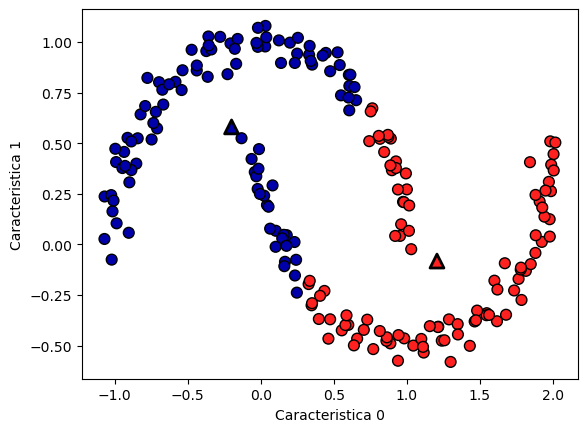

In [26]:
# generamos datos artificiales  two_moons con menor ruido
from sklearn.datasets import make_moons
X, y = make_moons(n_samples=200, noise=0.05, random_state=0)

# clustering en los datos en dos  clusteres
kmeans = KMeans(n_clusters=2)
kmeans.fit(X)
y_pred = kmeans.predict(X)

#  dibujamos las asignaciones de clúster y los centros de clúster
plt.scatter(X[:, 0], X[:, 1], c=y_pred, cmap= cm2, s=60, edgecolor='k')
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1],
            marker='^', c=[cm2(0), cm2(1)], s=100, linewidth=2,
            edgecolor='k')
plt.xlabel("Caracteristica 0")
plt.ylabel("Caracteristica 1")

### **Cuantización vectorial o k-means como método de descomposición**

Aunque k-means es un algoritmo de clustering, existen interesantes paralelismos con métodos de descomposición como PCA y NMF. Como se sabe, PCA busca las direcciones de máxima varianza en los datos, mientras que NMF intenta hallar componentes aditivos que suelen corresponder a "extremos" o "partes" de la información. Ambos enfoques representan cada punto de datos como una combinación lineal de varios componentes. 

En cambio, k-means representa cada punto mediante el centroide de su clúster, es decir, usando un único componente. Esta visión de k-means como un método de descomposición, en la que cada punto se cuantiza a un solo vector representativo, recibe el nombre de **cuantización vectorial**.

A continuación, compararemos PCA, NMF y k-means en paralelo, mostrando tanto los componentes extraídos (o centroides) como las reconstrucciones de las caras del conjunto de prueba usando 100 componentes. En el caso de k-means, la reconstrucción de cada punto corresponde al centroide más cercano encontrado durante el entrenamiento:



In [30]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.datasets import fetch_lfw_people
%matplotlib inline

personas = fetch_lfw_people(min_faces_per_person=20, resize=0.7)
imagen_shape = personas.images[0].shape

# Crea una máscara booleana seleccionando hasta 50 imágenes por persona
mascara = np.zeros(personas.target.shape, dtype=bool)   # <-- usa bool en lugar de np.bool
for objetivo in np.unique(personas.target):
    indices = np.where(personas.target == objetivo)[0][:50]
    mascara[indices] = True

X_personas = personas.data[mascara]
y_personas = personas.target[mascara]

# Escala valores de píxeles a [0,1] para estabilidad numérica
X_personas = X_personas / 255.0  


In [32]:
from sklearn.decomposition import NMF, PCA

X_entrenamiento, X_prueba, y_entrenamiento, y_prueba = train_test_split(X_personas,
                                        y_personas, stratify=y_personas, random_state=0)
nmf = NMF(n_components=100, random_state=0)
nmf.fit(X_entrenamiento)

pca = PCA(n_components=100, random_state=0)
pca.fit(X_entrenamiento)
kmeans = KMeans(n_clusters=100, random_state=0)
kmeans.fit(X_entrenamiento)

X_reconstruida_pca = pca.inverse_transform(pca.transform(X_prueba))
X_reconstruida_kmeans = kmeans.cluster_centers_[kmeans.predict(X_prueba)]
X_reconstruida_nmf = np.dot(nmf.transform(X_prueba), nmf.components_)

Text(0, 0.5, 'nmf')

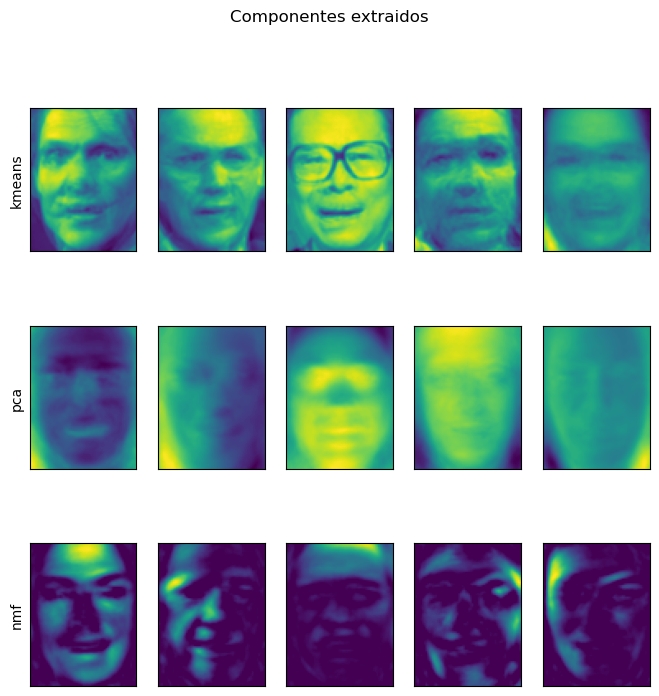

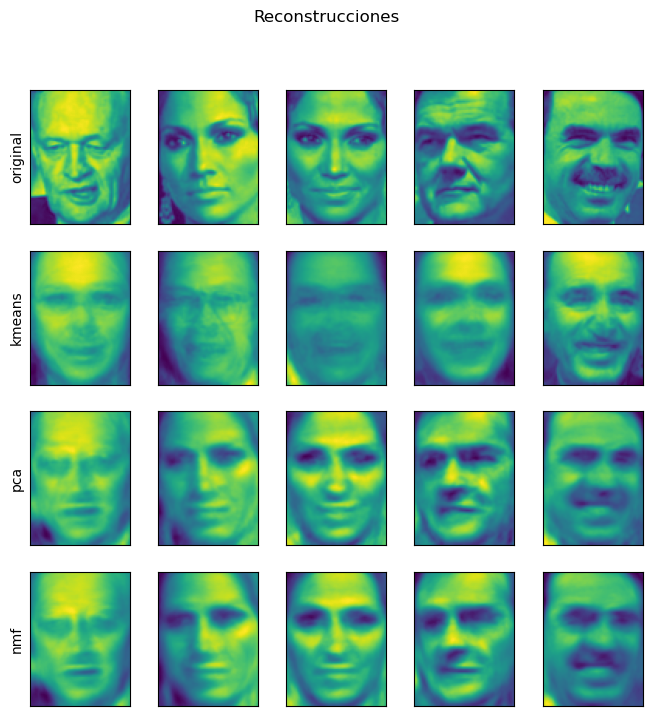

In [33]:
fig, axes = plt.subplots(3, 5, figsize=(8, 8),
subplot_kw={'xticks': (), 'yticks': ()})
fig.suptitle("Componentes extraidos")

for ax, comp_kmeans, comp_pca, comp_nmf in zip( axes.T, kmeans.cluster_centers_, pca.components_, nmf.components_):
    ax[0].imshow(comp_kmeans.reshape(imagen_shape))
    ax[1].imshow(comp_pca.reshape(imagen_shape), cmap='viridis')
    ax[2].imshow(comp_nmf.reshape(imagen_shape))
    
axes[0, 0].set_ylabel("kmeans")
axes[1, 0].set_ylabel("pca")
axes[2, 0].set_ylabel("nmf")

fig, axes = plt.subplots(4, 5, subplot_kw={'xticks': (), 'yticks': ()},figsize=(8, 8))
fig.suptitle("Reconstrucciones")
for ax, orig, rec_kmeans, rec_pca, rec_nmf in zip(axes.T, X_prueba, X_reconstruida_kmeans,
                                                  X_reconstruida_pca,X_reconstruida_nmf):
    ax[0].imshow(orig.reshape(imagen_shape))
    ax[1].imshow(rec_kmeans.reshape(imagen_shape))
    ax[2].imshow(rec_pca.reshape(imagen_shape))
    ax[3].imshow(rec_nmf.reshape(imagen_shape))

axes[0, 0].set_ylabel("original")
axes[1, 0].set_ylabel("kmeans")
axes[2, 0].set_ylabel("pca")
axes[3, 0].set_ylabel("nmf")

Un aspecto interesante de la cuantización vectorial con k-means es que podemos emplear muchos más clústeres que las dimensiones de entrada para codificar nuestros datos. Volvamos al conjunto de datos `two_moons`. 

Con PCA o NMF apenas podemos hacer algo útil, pues estos datos residen en un espacio bidimensional; reducirlos a una dimensión con cualquiera de estos métodos destruiría por completo su estructura. En cambio, con k-means podemos obtener una representación mucho más rica empleando un número mayor de centroides:


Miembros de los clustering:
[8 4 6 3 1 1 5 2 8 4 9 2 1 4 7 5 0 2 0 7 1 2 0 4 9 6 1 1 6 0 8 9 2 6 8 1 2
 5 3 6 2 7 8 6 4 9 5 7 6 2 7 2 1 3 4 8 0 4 0 9 2 3 1 8 4 3 9 4 9 3 2 3 2 6
 2 3 6 8 0 2 1 9 2 1 6 9 5 9 2 1 0 5 1 7 1 1 4 2 3 6 4 1 9 5 3 6 3 7 4 0 7
 9 9 3 8 4 8 1 2 8 8 7 6 9 6 7 5 6 4 1 5 7 3 6 4 4 4 3 1 8 6 6 0 9 7 5 6 4
 0 6 2 4 8 0 2 9 4 2 0 0 6 4 0 4 2 1 0 2 4 2 0 3 3 7 6 2 1 7 7 0 4 3 1 4 1
 0 9 2 3 7 3 0 8 5 6 7 1 6 9 4]


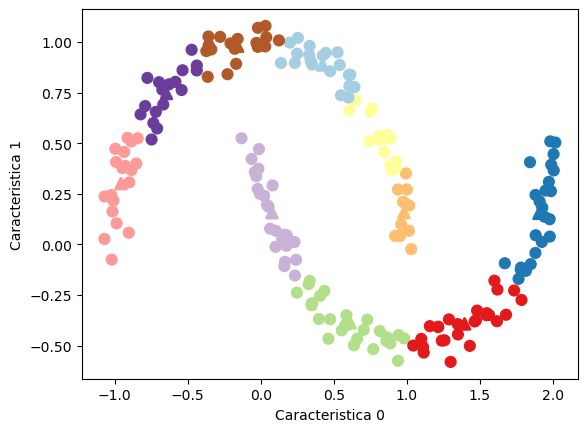

In [35]:
X, y = make_moons(n_samples=200, noise=0.05, random_state=0)
kmeans = KMeans(n_clusters=10, random_state=0)
kmeans.fit(X)
y_pred = kmeans.predict(X)

plt.scatter(X[:, 0], X[:, 1], c=y_pred, s=60, cmap='Paired')
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s=60,
marker='^', c=range(kmeans.n_clusters), linewidth=2, cmap='Paired')

plt.xlabel("Caracteristica 0")
plt.ylabel("Caracteristica 1")
print("Miembros de los clustering:\n{}".format(y_pred))

Usamos 10 centros de clúster, lo que significa que a cada punto se le asigna un número entre `0` y `9`. Podemos ver esto como datos representados con 10 componentes (es decir, disponemos de 10 nuevas características), en las que todas las dimensiones están en cero, salvo aquella que indica el centro del clúster al que está asignado el punto. Gracias a esta representación en 10 dimensiones, ahora sería posible separar las dos "medias lunas" con un modelo lineal, algo que no hubiese sido factible con las dos características originales.

También podemos obtener una representación aún más expresiva usando, como características, las distancias a cada uno de los centros de clúster. Esto se logra fácilmente con el método `transform` de `KMeans`:


In [37]:
distancia_caracteristica = kmeans.transform(X)
print("Dimension de las distancia caracteristica : {}".format(distancia_caracteristica.shape))
print("Distancia caracteristica:\n{}".format(distancia_caracteristica))

Dimension de las distancia caracteristica : (200, 10)
Distancia caracteristica:
[[0.53664613 1.15017588 0.93237626 ... 1.48034956 0.002907   1.07736639]
 [1.74138152 0.60592307 1.00666225 ... 2.52921971 1.20779969 2.23716489]
 [0.75710543 1.93145038 0.91586549 ... 0.78321505 0.87573753 0.71838465]
 ...
 [0.9274342  1.73811046 0.57899268 ... 1.11471941 0.83358544 1.04125672]
 [0.3227627  1.97647071 1.47861069 ... 0.81425026 0.84551232 0.28446737]
 [1.63322944 0.47226506 1.02289983 ... 2.46626118 1.09767675 2.14812753]]


**Limitaciones de k-means**

El algoritmo **k-means** es uno de los más populares para el **agrupamiento**, no solo porque resulta relativamente fácil de entender e implementar, sino también porque ofrece un rendimiento rápido. Además, **scikit-learn** incluye la clase `MiniBatchKMeans`, una variante aún más escalable capaz de procesar conjuntos de datos de gran tamaño.

Sin embargo, k-means presenta algunas limitaciones:

1. **Inicialización aleatoria**: el resultado depende de la semilla. Por defecto, scikit-learn ejecuta el algoritmo 10 veces con 10 inicializaciones distintas y devuelve el mejor resultado.
2. **Suposiciones sobre la forma de los clústeres**: k-means asume clústeres aproximadamente esféricos y de tamaño similar.
3. **Número de clústeres predefinido**: es necesario especificar de antemano el valor de *k*, lo cual puede no ser evidente en aplicaciones del mundo real.

Para mitigar estos inconvenientes, a menudo se emplean estrategias como:

* Inicialización mejorada (p. ej., **k-means++**).
* Validación de clústeres (métricas de silueta, índice de Calinski–Harabasz, etc.).
* Métodos alternativos basados en densidad o en grafos, cuando la forma de los grupos es irregular.
